# 1. Thư viện sử dụng

In [37]:
import os
import glob
import numpy as np
import json
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import time
import uuid # tạo tên cho ảnh
import albumentations as alb # tăng cường tập dữ liệu huấn luyện
import random
import shutil # di chuyển file
from tensorflow.keras.models import load_model

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# 2. Tạo dữ liệu Huấn luyện

In [4]:
IMAGES_PATH = os.path.join('data','images')
number_images = 50

### 2.1. Lấy ảnh từ video

In [8]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### 2.2. Gán nhãn dữ liệu
- Mắt trái
- Mắt phải

In [11]:
!labelme

2023-03-31T10:21:51.285ZE [20592:ShellIpcClient] shell_ipc_client.cc:137:Connect Can't connect to socket at: \\.\Pipe\GoogleDriveFSPipe_truon_shell
2023-03-31T10:21:51.286ZE [20592:ShellIpcClient] shell_ipc_client.cc:620:operator() Failed to connect to the server: NOT_FOUND: Can't connect to socket at: \\.\Pipe\GoogleDriveFSPipe_truon_shell
=== Source Location Trace: ===
apps/drive/fs/ipc/shell_ipc_client.cc:138

2023-03-31T10:21:51.286ZE [17728:ShellIpcClient] shell_ipc_client.cc:137:Connect Can't connect to socket at: \\.\Pipe\GoogleDriveFSPipe_truon_shell
2023-03-31T10:21:51.286ZE [17728:ShellIpcClient] shell_ipc_client.cc:620:operator() Failed to connect to the server: NOT_FOUND: Can't connect to socket at: \\.\Pipe\GoogleDriveFSPipe_truon_shell
=== Source Location Trace: ===
apps/drive/fs/ipc/shell_ipc_client.cc:138

2023-03-31T10:21:51.286ZE [17228:ShellIpcClient] shell_ipc_client.cc:137:Connect Can't connect to socket at: \\.\Pipe\GoogleDriveFSPipe_truon_shell
2023-03-31T10:21:5

In [12]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [13]:
images = tf.data.Dataset.list_files('data/images/*.jpg')
images.as_numpy_iterator().next()

b'data\\images\\11d2c090-cf13-11ed-bb61-706655b34db8.jpg'

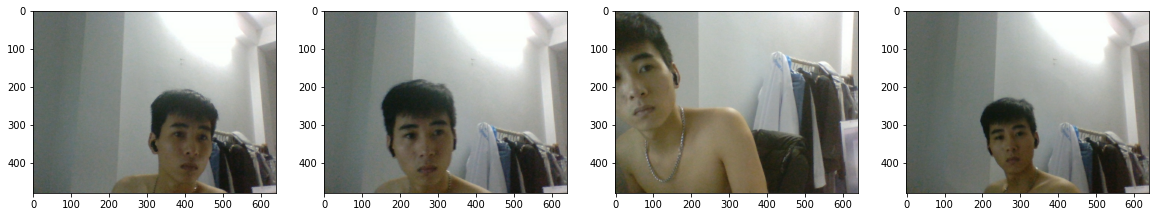

In [14]:
images = images.map(load_image)
images.as_numpy_iterator().next()
type(images)
image_generator = images.batch(4).as_numpy_iterator()
plot_images = image_generator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

### 2.3. Chia dữ liệu train/test/val

In [15]:
train_dir = "data/train"
test_dir = "data/test"
val_dir = "data/val"

train_images_dir = os.path.join(train_dir, "images")
train_labels_dir = os.path.join(train_dir, "labels")

test_images_dir = os.path.join(test_dir, "images")
test_labels_dir = os.path.join(test_dir, "labels")

val_images_dir = os.path.join(val_dir, "images")
val_labels_dir = os.path.join(val_dir, "labels")

for directory in [train_images_dir, train_labels_dir, test_images_dir, test_labels_dir, val_images_dir, val_labels_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)

In [16]:
image_files = glob.glob('data/images/*.jpg')
random.shuffle(image_files)

train_split = int(len(image_files) * 0.7)
val_split = int(len(image_files) * 0.2)

train_files = image_files[:train_split]
val_files = image_files[train_split:train_split+val_split]
test_files = image_files[train_split+val_split:]

In [17]:
for file in train_files:
    image_file = file
    label_file = 'data/labels/' + os.path.splitext(os.path.basename(image_file))[0] + '.json'
    shutil.copy2(image_file, 'data/train/images')
    shutil.copy2(label_file, 'data/train/labels')

for file in val_files:
    image_file = file
    label_file = 'data/labels/' + os.path.splitext(os.path.basename(image_file))[0] + '.json'
    shutil.copy2(image_file, 'data/val/images')
    shutil.copy2(label_file, 'data/val/labels')

for file in test_files:
    image_file = file
    label_file = 'data/labels/' + os.path.splitext(os.path.basename(image_file))[0] + '.json'
    shutil.copy2(image_file, 'data/test/images')
    shutil.copy2(label_file, 'data/test/labels')

### 2.4. Tăng cường ảnh huấn luyện

In [18]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):

        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)

In [19]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                                alb.HorizontalFlip(p=0.5),
                                alb.RandomBrightnessContrast(p=0.2),
                                alb.RandomGamma(p=0.2),
                                alb.RGBShift(p=0.2),
                                alb.VerticalFlip(p=0.5)],
                        keypoint_params=alb.KeypointParams(format='xy', label_fields=['class_labels']))

In [21]:
for partition in ['train', 'test', 'val']:
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        classes = [0,0]
        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            if label['shapes'][0]['label']=='mat_trai':
                classes[0] = 1
                coords[0] = np.squeeze(label['shapes'][0]['points'])[0]
                coords[1] = np.squeeze(label['shapes'][0]['points'])[1]

            if label['shapes'][0]['label']=='mat_phai':
                classes[1] = 1
                coords[2] = np.squeeze(label['shapes'][0]['points'])[0]
                coords[3] = np.squeeze(label['shapes'][0]['points'])[1]

            if len(label['shapes']) > 1:
                if label['shapes'][1]['label'] =='mat_trai':
                    classes[0] = 1
                    coords[0] = np.squeeze(label['shapes'][1]['points'])[0]
                    coords[1] = np.squeeze(label['shapes'][1]['points'])[1]

                if label['shapes'][1]['label'] =='mat_phai':
                    classes[1] = 1
                    coords[2] = np.squeeze(label['shapes'][1]['points'])[0]
                    coords[3] = np.squeeze(label['shapes'][1]['points'])[1]
            np.divide(coords, [640,480,640,480])
        try:
            for x in range(120):
                keypoints = [(coords[:2]), (coords[2:])]
                augmented = augmentor(image=img, keypoints=keypoints, class_labels=['mat_trai','mat_phai'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])
                annotation = {}
                annotation['image'] = image
                annotation['class'] = [0,0]
                annotation['keypoints'] = [0,0,0,0]
                if os.path.exists(label_path):
                    if len(augmented['keypoints']) > 0:
                        for idx, cl in enumerate(augmented['class_labels']):
                            if cl == 'mat_trai':
                                annotation['class'][0] = 1
                                annotation['keypoints'][0] = augmented['keypoints'][idx][0]
                                annotation['keypoints'][1] = augmented['keypoints'][idx][1]
                            if cl == 'mat_phai':
                                annotation['class'][1] = 1
                                annotation['keypoints'][2] = augmented['keypoints'][idx][0]
                                annotation['keypoints'][3] = augmented['keypoints'][idx][1]
                annotation['keypoints'] = list(np.divide(annotation['keypoints'], [450,450,450,450]))
                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

# 3. Load Data

### 3.1. Load Img

In [22]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (250,250)))
train_images = train_images.map(lambda x: x/255)

test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (250,250)))
test_images = test_images.map(lambda x: x/255)

val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (250,250)))
val_images = val_images.map(lambda x: x/255)

### 3.2. Load Label

In [23]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
    return [label['keypoints']]

# tf.data.Dataset.list_files: lệt kê danh sách tệp nhãn có đuôi .json
# tf.py_function để sử dụng hàm load_labels và truyền vào đường dẫn của từng tệp nhãn

train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

### 3.3. Kết hợp Img và Labels

In [24]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3480, 3480, 600, 600, 960, 960)

In [25]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(4000) # Xáo trộn dữ liệu
train = train.batch(16) # Chia dữ liệu thành các batch, cho quá trình huấn luyện mini-batch gradient descent.
train = train.prefetch(4) # Tải dữ liệu cho batch tiếp theo

In [26]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1000)
test = test.batch(16)
test = test.prefetch(4)

In [27]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1200)
val = val.batch(16)
val = val.prefetch(4)

### 3.4. Xem dữ liệu

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


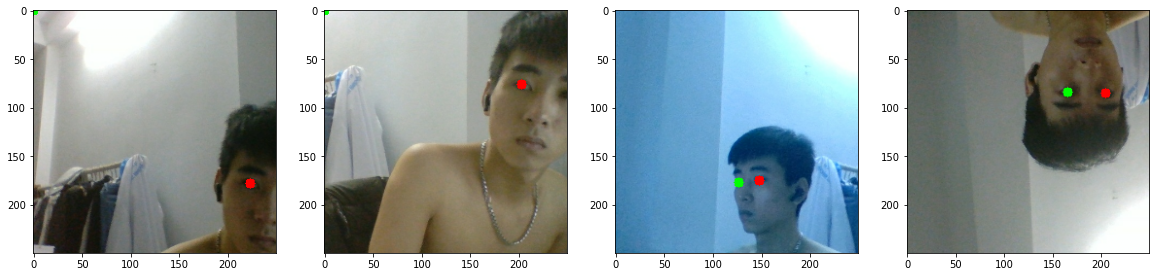

In [29]:
data_samples = train.as_numpy_iterator()
res = data_samples.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][0][idx]

    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 5, (255,0,0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 5, (0,255,0), -1)

    ax[idx].imshow(sample_image)

# 4.Xây dựng mô hình

### 4.1. Xây dựng mạng Học sâu

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Reshape, Dropout
from tensorflow.keras.applications import ResNet50

In [31]:
model = Sequential([
    Input(shape =(250, 250, 3)),
    ResNet50(include_top= False, weights= 'imagenet', input_shape=(250,250,3)),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(256, 3, 2, padding='same', activation='relu'),
    Conv2D(256, 2, 2, activation='relu'),
    Dropout(0.05),
    Conv2D(4, 2, 2),
    Reshape((4,))
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 512)         9437696   
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 512)         2359808   
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         1179904   
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 256)         262400    
                                                                 
 dropout (Dropout)           (None, 2, 2, 256)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 1, 4)           4

### 4.2. Thiết lập hàm tối ưu và hàm Loss

In [32]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch
print(lr_decay)
optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001, decay= lr_decay)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer, loss)

0.0015290519877675837


### 4.3. Huấn luyện mô hình

In [33]:
hist = model.fit(train, epochs= 50, validation_data= val)

Epoch 1/50
218/218 [==============================] - 81s 284ms/step - loss: 2.6758 - val_loss: 0.1169
Epoch 2/50
218/218 [==============================] - 63s 271ms/step - loss: 0.0093 - val_loss: 0.0926
Epoch 3/50
218/218 [==============================] - 62s 271ms/step - loss: 0.0045 - val_loss: 0.1201
Epoch 4/50
218/218 [==============================] - 62s 271ms/step - loss: 0.0030 - val_loss: 0.0760
Epoch 5/50
218/218 [==============================] - 62s 272ms/step - loss: 0.0021 - val_loss: 0.0265
Epoch 6/50
218/218 [==============================] - 62s 272ms/step - loss: 0.0018 - val_loss: 0.0113
Epoch 7/50
218/218 [==============================] - 63s 276ms/step - loss: 0.0019 - val_loss: 0.0113
Epoch 8/50
218/218 [==============================] - 64s 274ms/step - loss: 0.0014 - val_loss: 0.0093
Epoch 9/50
218/218 [==============================] - 63s 274ms/step - loss: 0.0012 - val_loss: 0.0083
Epoch 10/50
218/218 [==============================] - 63s 274ms/step - l

### 4.4. Kiểm định mô hình

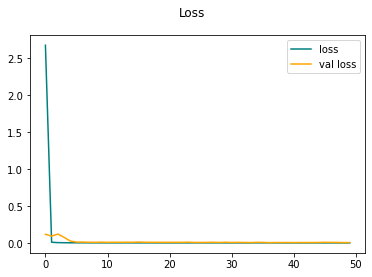

In [34]:
hist.history
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val loss')
plt.suptitle('Loss')
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


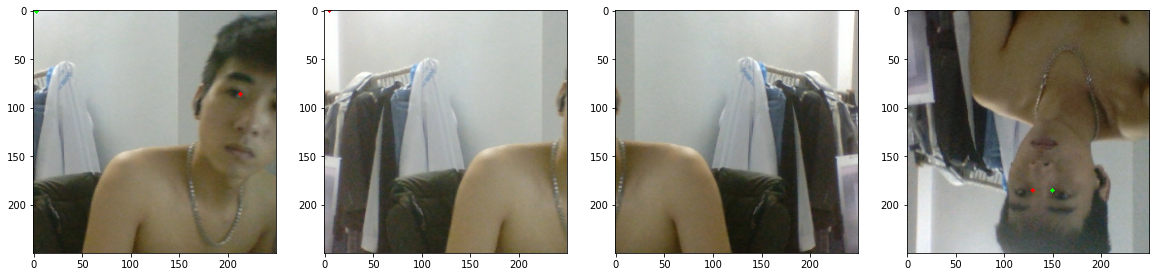

In [35]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = model.predict(test_sample[0])
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[idx]

    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 2, (0,255,0), -1)

    ax[idx].imshow(sample_image)

In [38]:
model.save('eyetrackerresnet.h5')
model = load_model('eyetrackerresnet.h5')
model.predict(test_sample[0])

array([[ 2.8990402e+00,  1.3811976e+00,  3.6743608e+00,  2.1631706e+00],
       [ 4.1987634e-01, -1.5772924e-02,  5.9309834e-01,  6.2957537e-01],
       [ 7.4943626e-01, -8.7142646e-02,  7.1935892e-01,  8.3450007e-01],
       [ 1.3872535e+00,  7.2650080e+00,  1.5531605e+00,  6.0403695e+00],
       [-4.6690628e-03,  4.0981621e-03, -2.9731831e-03,  3.6940351e-04],
       [ 8.1541145e-01,  6.8368500e-01, -6.4794393e-03,  3.1226361e-03],
       [ 1.9908708e-01,  7.2647238e-01,  3.6483294e-01,  7.2412813e-01],
       [ 7.8635323e-01,  4.2392564e-01,  2.0279882e-02, -3.7554055e-03],
       [ 7.1161437e-01,  7.4309742e-01,  5.6288946e-01,  7.4634010e-01],
       [ 8.7741852e-01,  2.5111753e-01,  7.4622816e-01,  2.2971950e-01],
       [ 3.9847371e-01,  6.4440626e-01,  5.6375182e-01,  6.4696717e-01],
       [ 2.1167442e-02,  3.2685526e-02, -8.7819630e-03,  1.1346303e-04],
       [ 8.4836829e-01,  6.5176934e-01,  7.9339417e-03,  3.6200080e-03],
       [ 2.2946417e-01,  4.2649943e-01,  5.9948210e

# 5.Thực nghiệm với thời gian thực

In [39]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()

    frame = frame[50:500,50:500,:]
    rgb_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(rgb_img, (250,250))

    yhat = model.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[0,:4]

    cv2.circle(frame, tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(frame, tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 2, (0,255,0), -1)
    cv2.imshow('EyeTrack', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()